# 0. Imports

In [1]:
from functools import partial
import os
from pathlib import Path

from IPython.display import HTML
import jax
import jax.numpy as jnp
import jax.random as jr
from jax.scipy import stats
import matplotlib.pyplot as plt
from matplotlib import animation, rc
import numpy as np
from tqdm import tqdm
from time import time
import optax

from demos.showdown.classification import (
    classification_train as benchmark,
    hparam_tune_clf as hpt
)
from rebayes.datasets import classification_data as data_utils
from rebayes.datasets import rotating_permuted_mnist_data as rmnist_data

2023-05-30 17:14:27.036417: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: libnvinfer.so.7: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: :/usr/local/lib
2023-05-30 17:14:27.036569: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer_plugin.so.7'; dlerror: libnvinfer_plugin.so.7: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: :/usr/local/lib
2023-05-30 17:14:27.036580: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Cannot dlopen some TensorRT libraries. If you would like to use Nvidia GPU with TensorRT, please make sure the missing libraries mentioned above are installed properly.


In [2]:
%load_ext autoreload
%autoreload 2

In [3]:
# Initialize model
mlp_st_init_fn = lambda key, bwc_ratio: \
    benchmark.init_model(type='mlp', features=(100, 100, 10), key=key, rescale=False)

In [4]:
dataset_st = data_utils.load_mnist_dataset(fashion=False) # load data
model_dict_st = benchmark.init_model(type='mlp', features=(100, 100, 10), key=0, rescale=False)

2023-05-30 17:14:31.291995: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcuda.so.1'; dlerror: libcuda.so.1: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: :/usr/local/lib
2023-05-30 17:14:31.292036: W tensorflow/compiler/xla/stream_executor/cuda/cuda_driver.cc:265] failed call to cuInit: UNKNOWN ERROR (303)


In [5]:
# Select 9 random images (different digits) from the test set
X_st_test, y_st_test = dataset_st['test']
# Select 9 different digits from test set
test_st_images = X_st_test[jnp.array([jr.choice(jr.PRNGKey(i), jnp.where(y_st_test == i)[0]) for i in range(10)])]

# Introduce a randomly permuted image as an OOD sample
ood_st_img = jr.choice(jr.PRNGKey(0), test_st_images)
ood_st_img = jr.permutation(jr.PRNGKey(0), ood_st_img.ravel()).reshape(ood_st_img.shape)

In [6]:
all_test_st_images = jnp.concatenate([test_st_images, ood_st_img[None, ...]], axis=0)
all_test_st_labels = jnp.concatenate([jnp.arange(10), jnp.array([0])])

# 1. Stationary MNIST

## 1.1 LOFI-10

### 1.1.1 NLL

In [ ]:
X_st_train, y_st_train = dataset_st['train']
train_st = (X_st_train[:500], y_st_train[:500])
kwargs = {
    'memory_size': 10,
    'inflation': "hybrid",
    'lofi_method': "diagonal",
}
pbounds={
    'log_init_cov': (-10.0, 0.0),
    'log_bwc_ratio': (-40.0, -40.0),
    'log_dynamics_weights': (-90, -90),
    'log_dynamics_cov': (-90, -90),
    'log_alpha': (-40, -40),
    'log_temperature': (-40.0, -40.0)
}
agent_type = 'lofi'
init_points, n_iter = 5, 10

ll_callback = partial(benchmark.eval_callback, evaluate_fn=benchmark.mnist_evaluate_ll)
# ll_callback=benchmark.eval_lpd_mc_callback
optimizer_st = hpt.create_optimizer(
    mlp_st_init_fn, pbounds, train_st, dataset_st['val'], callback=ll_callback, 
    method=agent_type, verbose=2, n_seeds=2, callback_at_end=False, **kwargs
)

optimizer_st.maximize(
    init_points=init_points,
    n_iter=n_iter,
)
best_hparams = hpt.get_best_params(optimizer_st, method=agent_type)
print(f"Best target: {optimizer_st.max['target']}")

In [ ]:
estimator_st, init_mean_st, init_cov_st, *_, apply_fn_st = hpt.build_estimator(
    mlp_st_init_fn,
    best_hparams,
    method=agent_type,
    **kwargs,
)

In [ ]:
# Train
def map_callback(bel, *args, **kwargs):
    return bel

_, outputs = estimator_st.scan(init_mean_st, init_cov_st, X_st_train[:500], y_st_train[:500], map_callback)

In [ ]:
# 11x10 grid
frames = jnp.arange(0, 500, 50)
n_test_images = 11
fig, axs = plt.subplots(n_test_images, len(frames), figsize=(20, 20))

for i, frame in enumerate(frames):
    for j in range(n_test_images):
        if j < 10:
            curr_img = test_st_images[j]
        else:
            curr_img = ood_st_img
        ax = axs[j][i]
        ax.imshow(curr_img, cmap='gray', extent=[0, 10, 0, 1], aspect='auto', alpha=0.3)
        ax.set_xticks(list(range(10)) + [10])
        ax.set_xticklabels(list(map(str, range(10))) + ['nll'])
        ax.set_ylim(0, 1)
        ax.set_yticks([])

        ax2 = ax.twinx()
        ax2.set_ylim(0, 3.0)
        ax2.set_yticks([])

        logits = model_dict_st['apply_fn'](outputs.mean[frame], curr_img.reshape(1, 28, 28, 1))
        preds = jax.nn.softmax(logits).ravel()
        nll = optax.softmax_cross_entropy_with_integer_labels(logits, jnp.array(j))
        
        ax.bar(range(10), preds, color='blue')
        ax2.bar(10, nll, color='red')
        
        ax.set_title(f"Prediction: {preds.argmax()}")
    
    fig.text(0.5 / len(frames) + i / len(frames), 0.04, f'n_obs: {frame}', ha='center')

plt.tight_layout()
plt.subplots_adjust(top=0.95, bottom=0.07)  # Make room for the column titles
plt.show()


### 1.1.2 NLPD (Hot Posterior)

In [ ]:
X_st_train, y_st_train = dataset_st['train']
train_st = (X_st_train[:500], y_st_train[:500])
kwargs = {
    'memory_size': 10,
    'inflation': "hybrid",
    'lofi_method': "diagonal",
}
pbounds={
    'log_init_cov': (-10.0, 0.0),
    'log_bwc_ratio': (-40.0, -40.0),
    'log_dynamics_weights': (-90, -90),
    'log_dynamics_cov': (-90, -90),
    'log_alpha': (-40, -40),
    'log_temperature': (0.0, 0.0)
}
agent_type = 'lofi'
init_points, n_iter = 5, 10

ll_callback=partial(benchmark.eval_lpd_mc_callback, n_samples=500)
optimizer_st_nlpd = hpt.create_optimizer(
    mlp_st_init_fn, pbounds, train_st, dataset_st['val'], callback=ll_callback, 
    method=agent_type, verbose=2, n_seeds=2, callback_at_end=False, **kwargs
)

optimizer_st_nlpd.maximize(
    init_points=init_points,
    n_iter=n_iter,
)
best_hparams_st_nlpd = hpt.get_best_params(optimizer_st_nlpd, method=agent_type)
print(f"Best target: {optimizer_st_nlpd.max['target']}")

In [ ]:
estimator_st_nlpd, init_mean_st_nlpd, init_cov_st_nlpd, _, tmp, apply_fn_st_nlpd = \
    hpt.build_estimator(
    mlp_st_init_fn,
    best_hparams_st_nlpd,
    method=agent_type,
    **kwargs,
)

In [ ]:
# Train
def mc_callback(bel, pred_obs, t, xt, yt, bel_pred, **kwargs):
    key = jr.fold_in(kwargs["key"], t)
    agent, images = kwargs["agent"], kwargs["images"]
    def mc_prediction(img, key):
        img = img.reshape(1, 28, 28, 1)
        y_samples = agent.pred_obs_mc(bel_pred, key, img, 500)
        
        return y_samples
    keys = jr.split(key, len(images))
    preds = jax.vmap(mc_prediction)(images, keys)

    return preds, bel

test_kwargs = {
    "agent": estimator_st_nlpd,
    "key": jr.PRNGKey(0),
    "images": all_test_st_images
}
_, mc_outputs = estimator_st_nlpd.scan(init_mean_st_nlpd, init_cov_st_nlpd,
                                       X_st_train[:500], y_st_train[:500], mc_callback, **test_kwargs)

In [ ]:
mc_preds, mc_bels = mc_outputs

In [ ]:
# 11x10 grid
frames = jnp.arange(0, 500, 50)
n_test_images = 11
fig, axs = plt.subplots(n_test_images, len(frames), figsize=(20, 20))

for i, frame in enumerate(frames):
    for j in range(n_test_images):
        key = jr.fold_in(jr.PRNGKey(i), j)
        if j < 10:
            curr_img = test_st_images[j]
        else:
            curr_img = ood_st_img
        ax = axs[j][i]
        ax.imshow(curr_img, cmap='gray', extent=[0, 10, 0, 1], aspect='auto', alpha=0.3)
        ax.set_xticks(list(range(10)) + [10])
        ax.set_xticklabels(list(map(str, range(10))) + ['nlpd'])
        ax.set_ylim(0, 1)
        ax.set_yticks([])

        ax2 = ax.twinx()
        ax2.set_ylim(0, 3.0)
        ax2.set_yticks([])
        
        preds = mc_preds[frame, j].argmax(axis=-1)
        pred_obs = jax.nn.one_hot(preds, 10).mean(axis=0)
        
        curr_bel = jax.tree_util.tree_map(lambda x: x[frame], mc_bels)
        nlpd = estimator_st_nlpd.nlpd_mc(curr_bel, key, curr_img.reshape(1, 28, 28, 1), 
                                         all_test_st_labels[j], temperature=tmp)
        
        ax.bar(range(10), pred_obs, color='blue')
        ax2.bar(10, nlpd, color='red')
        
        ax.set_title(f"Prediction: {pred_obs.argmax()}")
    
    fig.text(0.5 / len(frames) + i / len(frames), 0.04, f'n_obs: {frame}', ha='center')

plt.tight_layout()
plt.subplots_adjust(top=0.95, bottom=0.07)  # Make room for the column titles
plt.show()


## 1.2 RSGD-10

### 1.2.1 NLL

### 1.2.2 NLPD

# 2. Nonstationary PMNIST

## 2.1 LOFI-10

In [20]:
n_tasks, ntest_per_task = 5, 20
data_kwargs = {
    'n_tasks': n_tasks,
    'ntrain_per_task': 300,
    'nval_per_task': 1,
    'ntest_per_task': ntest_per_task,
}

dataset_nst = data_utils.load_permuted_mnist_dataset(**data_kwargs, fashion=True) # load data
dataset_nst_load_fn = partial(data_utils.load_permuted_mnist_dataset, **data_kwargs, fashion=True)

In [49]:
# Select 9 random images (different digits) from the test set
X_nst_test, y_nst_test = dataset_nst['test']
# Select 9 different digits from test set
test_idx = jnp.arange(ntest_per_task//3, n_tasks*ntest_per_task, ntest_per_task)
test_nst_images, test_nst_labels = X_nst_test[test_idx], y_nst_test[test_idx]

# Introduce an MNIST image as an OOD sample
dataset_st = data_utils.load_mnist_dataset(fashion=False) # load data
X_st_test, y_st_test = dataset_st['test']
del dataset_st

ood_idx = jr.choice(jr.PRNGKey(0), X_st_test.shape[0])
ood_nst_img, ood_nst_label = X_st_test[ood_idx], y_st_test[ood_idx]

In [50]:
all_test_nst_images = jnp.concatenate([test_nst_images, ood_nst_img[None, ...]], axis=0)
all_test_nst_labels = jnp.concatenate([test_nst_labels, jnp.array([ood_nst_label])], axis=0)

### 2.1.1 NLL

In [23]:
X_nst_train, y_nst_train = dataset_nst['train']
train_nst = (X_nst_train, y_nst_train)
kwargs = {
    'memory_size': 10,
    'inflation': "hybrid",
    'lofi_method': "diagonal",
}
pbounds={
    'log_init_cov': (-10.0, 0.0),
    'log_bwc_ratio': (-40.0, -40.0),
    'log_dynamics_weights': (-90, -90),
    'log_dynamics_cov': (-20, 0.0),
    'log_alpha': (-40, -40),
    'log_temperature': (-40.0, -40.0)
}
agent_type = 'lofi'
init_points, n_iter = 5, 10

ll_callback = partial(
    benchmark.osa_eval_callback, 
    evaluate_fn=lambda y_pred, y: -optax.softmax_cross_entropy(y_pred, y).mean(),
)
optimizer_nst = hpt.create_optimizer(
    mlp_st_init_fn, pbounds, train_nst, dataset_nst['val'], callback=ll_callback, 
    method=agent_type, verbose=2, n_seeds=1, callback_at_end=False, **kwargs
)

optimizer_nst.maximize(
    init_points=init_points,
    n_iter=n_iter,
)
best_hparams = hpt.get_best_params(optimizer_nst, method=agent_type)
print(f"Best target: {optimizer_nst.max['target']}")

|   iter    |  target   | log_alpha | log_bw... | log_dy... | log_dy... | log_in... | log_te... |
-------------------------------------------------------------------------------------------------
| 1         | -2.093    | -40.0     | -40.0     | -7.945    | -90.0     | -5.763    | -40.0     |
| 2         | -2.354    | -40.0     | -40.0     | -0.7267   | -90.0     | -2.083    | -40.0     |
| 3         | -2.302    | -40.0     | -40.0     | -18.58    | -90.0     | -9.798    | -40.0     |
| 4         | -2.364    | -40.0     | -40.0     | -0.4276   | -90.0     | -5.385    | -40.0     |
| 5         | -2.093    | -40.0     | -40.0     | -17.13    | -90.0     | -4.782    | -40.0     |
| 6         | -2.059    | -40.0     | -40.0     | -12.44    | -90.0     | -4.796    | -40.0     |
| 7         | -2.354    | -40.0     | -40.0     | -14.56    | -90.0     | 0.0       | -40.0     |
| 8         | -2.118    | -40.0     | -40.0     | -11.24    | -90.0     | -7.84     | -40.0     |
| 9         | -2.026

In [25]:
# best_hparams
best_hparams = {
    'initial_covariance': 0.06942788518519619,
    'dynamics_covariance': 1.3068233514466364e-05,
    'dynamics_covariance_inflation_factor': 4.248354255291589e-18,
    'dynamics_weights': 1.0,
    'temperature': 4.248354255291589e-18,
    'bias_weight_cov_ratio': 4.248354255291589e-18
}

In [26]:
estimator_nst, init_mean_nst, init_cov_nst, *_, apply_fn_nst = hpt.build_estimator(
    mlp_st_init_fn,
    best_hparams,
    method=agent_type,
    **kwargs,
)

In [51]:
# Train
def map_nst_callback(bel, *args, **kwargs):
    test_imgs = kwargs['test_imgs']
    def compute_logits(img):
        logits = model_dict_st["apply_fn"](bel.mean, img.reshape(1, 28, 28, 1))
        return logits
    
    logits = jax.vmap(compute_logits)(test_imgs)
    
    return logits

test_kwargs = {
    "test_imgs": all_test_nst_images
}

_, outputs_nst = estimator_nst.scan(init_mean_nst, init_cov_nst, X_nst_train, y_nst_train, 
                                    map_nst_callback, **test_kwargs)

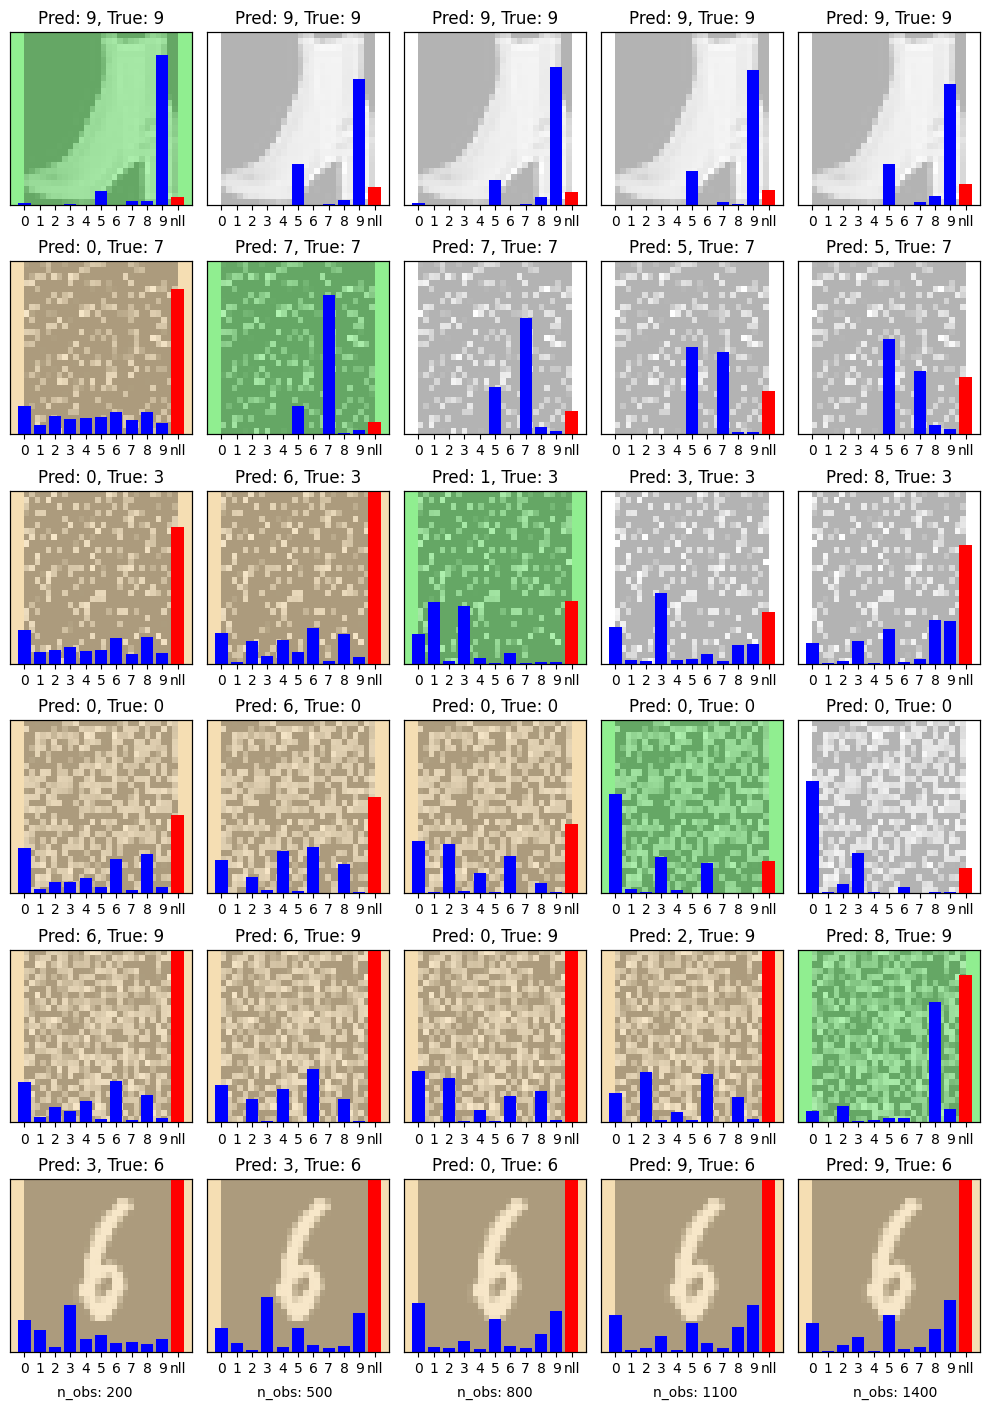

In [52]:
# 11x10 grid
frames = jnp.arange(200, 1_500, 300)
n_test_images = 6
fig, axs = plt.subplots(n_test_images, len(frames), figsize=(10, 15))

for i, frame in enumerate(frames):
    for j in range(n_test_images):
        curr_img = all_test_nst_images[j]
        ax = axs[j][i]
        ax.imshow(curr_img, cmap='gray', extent=[0, 10, 0, 1], aspect='auto', alpha=0.3)
        ax.set_xticks(list(range(10)) + [10])
        ax.set_xticklabels(list(map(str, range(10))) + ['nll'])
        ax.set_ylim(0, 1)
        ax.set_yticks([])

        ax2 = ax.twinx()
        ax2.set_ylim(0, 3.0)
        ax2.set_yticks([])

        logits = outputs_nst[frame, j]
        preds = jax.nn.softmax(logits).ravel()
        nll = optax.softmax_cross_entropy_with_integer_labels(logits, all_test_nst_labels[j])
        
        ax.bar(range(10), preds, color='blue')
        ax2.bar(10, nll, color='red')
        
        ax.set_title(f"Pred: {preds.argmax()}, True: {all_test_nst_labels[j]}")
        
        # Indicate current task
        if i  == j:
            ax.set_facecolor('lightgreen')
        elif i < j:
            ax.set_facecolor('wheat')
    
    fig.text(0.5 / len(frames) + i / len(frames), 0.04, f'n_obs: {frame}', ha='center')

plt.tight_layout()
plt.subplots_adjust(top=0.95, bottom=0.07)  # Make room for the column titles
plt.savefig("permuted_fmnist_clf_probe.pdf")
plt.show()


## 2.2 RSGD-10

In [ ]:
X_nst_train, y_nst_train = dataset_nst['train']
train_nst = (X_nst_train, y_nst_train)
kwargs = {
    'loss_fn': optax.softmax_cross_entropy,
    'buffer_size': 10,
    'dim_output': 10,
    "optimizer": "sgd",
}
pbounds = {
    'log_learning_rate': (-10, 0.0),
    'log_bwc_ratio': (-40.0, -40.0),
}
agent_type = 'sgd'
init_points, n_iter = 5, 5

ll_callback = partial(
    benchmark.osa_eval_callback, 
    evaluate_fn=lambda y_pred, y: -optax.softmax_cross_entropy(y_pred, y).mean(),
)
optimizer_nst = hpt.create_optimizer(
    mlp_st_init_fn, pbounds, train_nst, dataset_nst['val'], callback=ll_callback, 
    method=agent_type, verbose=2, n_seeds=1, callback_at_end=False, **kwargs
)

optimizer_nst.maximize(
    init_points=init_points,
    n_iter=n_iter,
)
best_hparams = hpt.get_best_params(optimizer_nst, method=agent_type)
print(f"Best target: {optimizer_nst.max['target']}")

In [ ]:
estimator_nst_rsgd, init_mean_nst_rsgd, init_cov_nst_rsgd, *_, apply_fn_nst_rsgd = hpt.build_estimator(
    mlp_st_init_fn,
    best_hparams,
    method=agent_type,
    **kwargs,
)

In [ ]:
_, outputs_nst_rsgd = estimator_nst_rsgd.scan(init_mean_nst_rsgd, init_cov_nst_rsgd, 
                                              X_nst_train, y_nst_train, 
                                              map_nst_callback, **test_kwargs)

In [ ]:
# 6x10 grid
frames = jnp.arange(50, 5_000, 500)
n_test_images = 6
fig, axs = plt.subplots(n_test_images, len(frames), figsize=(20, 15))

for i, frame in enumerate(frames):
    for j in range(n_test_images):
        curr_img = all_test_nst_images[j]
        ax = axs[j][i]
        ax.imshow(curr_img, cmap='gray', extent=[0, 10, 0, 1], aspect='auto', alpha=0.3)
        ax.set_xticks(list(range(10)) + [10])
        ax.set_xticklabels(list(map(str, range(10))) + ['nll'])
        ax.set_ylim(0, 1)
        ax.set_yticks([])

        ax2 = ax.twinx()
        ax2.set_ylim(0, 3.0)
        ax2.set_yticks([])

        logits = outputs_nst_rsgd[frame, j]
        preds = jax.nn.softmax(logits).ravel()
        nll = optax.softmax_cross_entropy_with_integer_labels(logits, all_test_nst_labels[j])
        
        ax.bar(range(10), preds, color='blue')
        ax2.bar(10, nll, color='red')
        
        ax.set_title(f"Pred.: {preds.argmax()}, True: {all_test_nst_labels[j]}")
        
        # Indicate current task
        if i // 2 == j:
            ax.set_facecolor('lightgreen')
        elif i // 2 < j:
            ax.set_facecolor('wheat')
    
    fig.text(0.5 / len(frames) + i / len(frames), 0.04, f'n_obs: {frame}', ha='center')

plt.tight_layout()
plt.subplots_adjust(top=0.95, bottom=0.07)  # Make room for the column titles
plt.show()


# 3. Nonstationary RMNIST Classification

In [ ]:
# Load MNIST dataset
mnist_dataset = data_utils.load_mnist_dataset(fashion=False)
n_train = 2_000
X_rot_train, y_rot_train = mnist_dataset['train']
X_rot_train, y_rot_train = X_rot_train[:n_train], y_rot_train[:n_train]
X_rot_test, y_rot_test = mnist_dataset['test']

# Generate discrete rotation angles
def generate_angle_fn(n_angles, min_angle, max_angle, increment=45.0):
    n_tasks = int((max_angle - min_angle) // increment + 1)
    n_angles_per_task = int(n_angles // n_tasks)
    result, curr_angle = [], min_angle
    for i in range(n_tasks):
        if i == n_tasks - 1:
            n_angles_per_task = n_angles
        result += [curr_angle] * n_angles_per_task
        n_angles -= n_angles_per_task
        curr_angle += increment
    result = jnp.array(result)
    
    return result, n_tasks, n_angles_per_task

min_angles, max_angles, increment = 0.0, 180.0, 45.0
angles_train, n_tasks_rot, _ = generate_angle_fn(len(X_rot_train), min_angles, max_angles, increment)
angles_test, _, ntest_per_task_rot = generate_angle_fn(len(X_rot_test), min_angles, max_angles, increment)

# Generate rotated MNIST dataset
X_rot_train = rmnist_data.rotate_mnist_dataset(X_rot_train, angles_train)
X_rot_test = rmnist_data.rotate_mnist_dataset(X_rot_test, angles_test)

## 3.1 LOFI-10

In [ ]:
train_rot = (X_rot_train, y_rot_train)
kwargs = {
    'memory_size': 10,
    'inflation': "hybrid",
    'lofi_method': "diagonal",
}
pbounds={
    'log_init_cov': (-10.0, 0.0),
    'log_bwc_ratio': (-40.0, -40.0),
    'log_dynamics_weights': (-90, -90),
    'log_dynamics_cov': (-20, 0.0),
    'log_alpha': (-40, -40),
    'log_temperature': (-40.0, -40.0)
}
agent_type = 'lofi'
init_points, n_iter = 5, 10

ll_callback = partial(
    benchmark.osa_eval_callback, 
    evaluate_fn=lambda y_pred, y: -optax.softmax_cross_entropy(y_pred, y).mean(),
)
optimizer_nst = hpt.create_optimizer(
    mlp_st_init_fn, pbounds, train_rot, train_rot, callback=ll_callback, 
    method=agent_type, verbose=2, n_seeds=1, callback_at_end=False, **kwargs
)

optimizer_nst.maximize(
    init_points=init_points,
    n_iter=n_iter,
)
best_hparams = hpt.get_best_params(optimizer_nst, method=agent_type)
print(f"Best target: {optimizer_nst.max['target']}")

In [ ]:
# best_hparams
best_hparams = {
    'initial_covariance': 0.05363468552651192,
    'dynamics_covariance': 5.3157380267683186e-05,
    'dynamics_covariance_inflation_factor': 4.248354255291589e-18,
    'dynamics_weights': 1.0,
    'temperature': 4.248354255291589e-18,
    'bias_weight_cov_ratio': 4.248354255291589e-18
}

In [ ]:
estimator_rot, init_mean_rot, init_cov_rot, *_, apply_fn_rot = hpt.build_estimator(
    mlp_st_init_fn,
    best_hparams,
    method=agent_type,
    **kwargs,
)

### 3.1.1 Random Target Digits

In [ ]:
# Select 5 random images (different digits) from test set
test_idx = jnp.arange(ntest_per_task_rot//4, n_tasks_rot*ntest_per_task_rot, ntest_per_task_rot)
test_rot_images, test_rot_labels = X_rot_test[test_idx], y_rot_test[test_idx]

# Introduce a fashion MNIST image as an OOD sample
fashion_mnist_dataset = data_utils.load_mnist_dataset(fashion=True)
X_fashion, y_fashion = fashion_mnist_dataset['test']

ood_idx = jr.choice(jr.PRNGKey(0), len(X_fashion))
ood_rot_img, ood_rot_label = X_fashion[ood_idx], y_fashion[ood_idx]

all_test_rot_images = jnp.concatenate([test_rot_images, ood_rot_img[None, ...]], axis=0)
all_test_rot_labels = jnp.concatenate([test_rot_labels, jnp.array([ood_rot_label])], axis=0)

In [ ]:
# Train
test_random_kwargs = {
    "test_imgs": all_test_rot_images
}

_, outputs_rot = estimator_rot.scan(init_mean_rot, init_cov_rot, X_rot_train, y_rot_train, 
                                    map_nst_callback, **test_random_kwargs)

In [ ]:
# 6x10 grid
frame_inc = n_train // 10
frames = jnp.arange(50, n_train, frame_inc)
n_test_images = n_tasks_rot + 1
fig, axs = plt.subplots(n_test_images, len(frames), figsize=(20, 15))

for i, frame in enumerate(frames):
    for j in range(n_test_images):
        curr_img = all_test_rot_images[j]
        ax = axs[j][i]
        ax.imshow(curr_img, cmap='gray', extent=[0, 10, 0, 1], aspect='auto', alpha=0.3)
        ax.set_xticks(list(range(10)) + [10])
        ax.set_xticklabels(list(map(str, range(10))) + ['nll'])
        ax.set_ylim(0, 1)
        ax.set_yticks([])

        ax2 = ax.twinx()
        ax2.set_ylim(0, 3.0)
        ax2.set_yticks([])

        logits = outputs_rot[frame, j]
        preds = jax.nn.softmax(logits).ravel()
        nll = optax.softmax_cross_entropy_with_integer_labels(logits, all_test_rot_labels[j])
        
        ax.bar(range(10), preds, color='blue')
        ax2.bar(10, nll, color='red')
        
        ax.set_title(f"Pred.: {preds.argmax()}")
        
        # Indicate current task
        if i // 2 == j:
            ax.set_facecolor('lightgreen')
        elif i // 2 < j:
            ax.set_facecolor('wheat')
    
    fig.text(0.5 / len(frames) + i / len(frames), 0.04, f'n_obs: {frame}', ha='center')

plt.tight_layout()
plt.subplots_adjust(top=0.95, bottom=0.07)  # Make room for the column titles
plt.show()


### 3.1.2 Target Digit = 3

In [ ]:
# Select 5 rotations of digit 3 from test set
X_rot_test, y_rot_test = mnist_dataset['test']
X_rot_test, y_rot_test = X_rot_test[y_rot_test == 3], y_rot_test[y_rot_test == 3]
angles_test, _, ntest_per_task_rot = generate_angle_fn(len(X_rot_test), min_angles, max_angles, increment)
X_rot_test = rmnist_data.rotate_mnist_dataset(X_rot_test, angles_test)

test_idx = jnp.arange(ntest_per_task_rot//4, n_tasks_rot*ntest_per_task_rot, ntest_per_task_rot)
test_rot_images, test_rot_labels = X_rot_test[test_idx], y_rot_test[test_idx]

# Introduce a fashion MNIST image as an OOD sample
fashion_mnist_dataset = data_utils.load_mnist_dataset(fashion=True)
X_fashion, y_fashion = fashion_mnist_dataset['test']

ood_idx = jr.choice(jr.PRNGKey(0), len(X_fashion))
ood_rot_img, ood_rot_label = X_fashion[ood_idx], y_fashion[ood_idx]

all_test_rot_images = jnp.concatenate([test_rot_images, ood_rot_img[None, ...]], axis=0)
all_test_rot_labels = jnp.concatenate([test_rot_labels, jnp.array([ood_rot_label])], axis=0)

In [ ]:
# Train
test_3_kwargs = {
    "test_imgs": all_test_rot_images
}

_, outputs_rot = estimator_rot.scan(init_mean_rot, init_cov_rot, X_rot_train, y_rot_train, 
                                    map_nst_callback, **test_3_kwargs)

In [ ]:
# 6x10 grid
frame_inc = n_train // 10
frames = jnp.arange(50, n_train, frame_inc)
n_test_images = n_tasks_rot + 1
fig, axs = plt.subplots(n_test_images, len(frames), figsize=(20, 15))

for i, frame in enumerate(frames):
    for j in range(n_test_images):
        curr_img = all_test_rot_images[j]
        ax = axs[j][i]
        ax.imshow(curr_img, cmap='gray', extent=[0, 10, 0, 1], aspect='auto', alpha=0.3)
        ax.set_xticks(list(range(10)) + [10])
        ax.set_xticklabels(list(map(str, range(10))) + ['nll'])
        ax.set_ylim(0, 1)
        ax.set_yticks([])

        ax2 = ax.twinx()
        ax2.set_ylim(0, 3.0)
        ax2.set_yticks([])

        logits = outputs_rot[frame, j]
        preds = jax.nn.softmax(logits).ravel()
        nll = optax.softmax_cross_entropy_with_integer_labels(logits, all_test_rot_labels[j])
        
        ax.bar(range(10), preds, color='blue')
        ax2.bar(10, nll, color='red')
        
        ax.set_title(f"Pred.: {preds.argmax()}")
        
        # Indicate current task
        if i // 2 == j:
            ax.set_facecolor('lightgreen')
        elif i // 2 < j:
            ax.set_facecolor('wheat')
    
    fig.text(0.5 / len(frames) + i / len(frames), 0.04, f'n_obs: {frame}', ha='center')

plt.tight_layout()
plt.subplots_adjust(top=0.95, bottom=0.07)  # Make room for the column titles
plt.show()


### 3.1.3 Target Digit = 8

In [ ]:
# Select 9 rotations of digit 3 from test set
X_rot_test, y_rot_test = mnist_dataset['test']
X_rot_test, y_rot_test = X_rot_test[y_rot_test == 8], y_rot_test[y_rot_test == 8]
angles_test, _, ntest_per_task_rot = generate_angle_fn(len(X_rot_test), min_angles, max_angles, increment)
X_rot_test = rmnist_data.rotate_mnist_dataset(X_rot_test, angles_test)

test_idx = jnp.arange(ntest_per_task_rot//4, n_tasks_rot*ntest_per_task_rot, ntest_per_task_rot)
test_rot_images, test_rot_labels = X_rot_test[test_idx], y_rot_test[test_idx]

# Introduce a fashion MNIST image as an OOD sample
fashion_mnist_dataset = data_utils.load_mnist_dataset(fashion=True)
X_fashion, y_fashion = fashion_mnist_dataset['test']

ood_idx = jr.choice(jr.PRNGKey(0), len(X_fashion))
ood_rot_img, ood_rot_label = X_fashion[ood_idx], y_fashion[ood_idx]

all_test_rot_images = jnp.concatenate([test_rot_images, ood_rot_img[None, ...]], axis=0)
all_test_rot_labels = jnp.concatenate([test_rot_labels, jnp.array([ood_rot_label])], axis=0)

In [ ]:
# Train
test_8_kwargs = {
    "test_imgs": all_test_rot_images
}

_, outputs_rot = estimator_rot.scan(init_mean_rot, init_cov_rot, X_rot_train, y_rot_train, 
                                    map_nst_callback, **test_8_kwargs)

In [ ]:
# 6x10 grid
frame_inc = n_train // 10
frames = jnp.arange(50, n_train, frame_inc)
n_test_images = n_tasks_rot + 1
fig, axs = plt.subplots(n_test_images, len(frames), figsize=(20, 15))

for i, frame in enumerate(frames):
    for j in range(n_test_images):
        curr_img = all_test_rot_images[j]
        ax = axs[j][i]
        ax.imshow(curr_img, cmap='gray', extent=[0, 10, 0, 1], aspect='auto', alpha=0.3)
        ax.set_xticks(list(range(10)) + [10])
        ax.set_xticklabels(list(map(str, range(10))) + ['nll'])
        ax.set_ylim(0, 1)
        ax.set_yticks([])

        ax2 = ax.twinx()
        ax2.set_ylim(0, 3.0)
        ax2.set_yticks([])

        logits = outputs_rot[frame, j]
        preds = jax.nn.softmax(logits).ravel()
        nll = optax.softmax_cross_entropy_with_integer_labels(logits, all_test_rot_labels[j])
        
        ax.bar(range(10), preds, color='blue')
        ax2.bar(10, nll, color='red')
        
        ax.set_title(f"Pred.: {preds.argmax()}")
        
        # Indicate current task
        if i // 2 == j:
            ax.set_facecolor('lightgreen')
        elif i // 2 < j:
            ax.set_facecolor('wheat')
    
    fig.text(0.5 / len(frames) + i / len(frames), 0.04, f'n_obs: {frame}', ha='center')

plt.tight_layout()
plt.subplots_adjust(top=0.95, bottom=0.07)  # Make room for the column titles
plt.show()


# 3.2 RSGD-10

In [ ]:
train_rot = (X_rot_train, y_rot_train)

kwargs = {
    'loss_fn': optax.softmax_cross_entropy,
    'buffer_size': 10,
    'dim_output': 10,
    "optimizer": "sgd",
}
pbounds = {
    'log_learning_rate': (-10, 0.0),
    'log_bwc_ratio': (-40.0, -40.0),
}
agent_type = 'sgd'
init_points, n_iter = 5, 5

ll_callback = partial(
    benchmark.osa_eval_callback, 
    evaluate_fn=lambda y_pred, y: -optax.softmax_cross_entropy(y_pred, y).mean(),
)
optimizer_nst = hpt.create_optimizer(
    mlp_st_init_fn, pbounds, train_rot, train_rot, callback=ll_callback, 
    method=agent_type, verbose=2, n_seeds=1, callback_at_end=False, **kwargs
)

optimizer_nst.maximize(
    init_points=init_points,
    n_iter=n_iter,
)
best_hparams = hpt.get_best_params(optimizer_nst, method=agent_type)
print(f"Best target: {optimizer_nst.max['target']}")

In [ ]:
# best_hparams
best_hparams = {
    'learning_rate': 0.010554865002632141,
    'bias_weight_cov_ratio': 4.248354255291589e-18
}

In [ ]:
estimator_rot_rsgd, init_mean_rot_rsgd, init_cov_rot_rsgd, *_, apply_fn_rot_rsgd = hpt.build_estimator(
    mlp_st_init_fn,
    best_hparams,
    method=agent_type,
    **kwargs,
)

### 3.2.1 Random Target Digits

In [ ]:
X_rot_test, y_rot_test = mnist_dataset['test']
min_angles, max_angles, increment = 0.0, 180.0, 45.0
angles_test, _, ntest_per_task_rot = generate_angle_fn(len(X_rot_test), min_angles, max_angles, increment)
X_rot_test = rmnist_data.rotate_mnist_dataset(X_rot_test, angles_test)

# Select 5 random images (different digits) from test set
test_idx = jnp.arange(ntest_per_task_rot//4, n_tasks_rot*ntest_per_task_rot, ntest_per_task_rot)
test_rot_images, test_rot_labels = X_rot_test[test_idx], y_rot_test[test_idx]

# Introduce a fashion MNIST image as an OOD sample
fashion_mnist_dataset = data_utils.load_mnist_dataset(fashion=True)
X_fashion, y_fashion = fashion_mnist_dataset['test']

ood_idx = jr.choice(jr.PRNGKey(0), len(X_fashion))
ood_rot_img, ood_rot_label = X_fashion[ood_idx], y_fashion[ood_idx]

all_test_rot_images = jnp.concatenate([test_rot_images, ood_rot_img[None, ...]], axis=0)
all_test_rot_labels = jnp.concatenate([test_rot_labels, jnp.array([ood_rot_label])], axis=0)

In [ ]:
# Train
test_random_kwargs = {
    "test_imgs": all_test_rot_images
}

_, outputs_rot_rsgd = estimator_rot_rsgd.scan(init_mean_rot_rsgd, init_cov_rot_rsgd, 
                                              X_rot_train, y_rot_train, 
                                              map_nst_callback, **test_random_kwargs)

In [ ]:
# 6x10 grid
frame_inc = n_train // 10
frames = jnp.arange(50, n_train, frame_inc)
n_test_images = n_tasks_rot + 1
fig, axs = plt.subplots(n_test_images, len(frames), figsize=(20, 15))

for i, frame in enumerate(frames):
    for j in range(n_test_images):
        curr_img = all_test_rot_images[j]
        ax = axs[j][i]
        ax.imshow(curr_img, cmap='gray', extent=[0, 10, 0, 1], aspect='auto', alpha=0.3)
        ax.set_xticks(list(range(10)) + [10])
        ax.set_xticklabels(list(map(str, range(10))) + ['nll'])
        ax.set_ylim(0, 1)
        ax.set_yticks([])

        ax2 = ax.twinx()
        ax2.set_ylim(0, 3.0)
        ax2.set_yticks([])

        logits = outputs_rot_rsgd[frame, j]
        preds = jax.nn.softmax(logits).ravel()
        nll = optax.softmax_cross_entropy_with_integer_labels(logits, all_test_rot_labels[j])
        
        ax.bar(range(10), preds, color='blue')
        ax2.bar(10, nll, color='red')
        
        ax.set_title(f"Pred.: {preds.argmax()}")
        
        # Indicate current task
        if i // 2 == j:
            ax.set_facecolor('lightgreen')
        elif i // 2 < j:
            ax.set_facecolor('wheat')
    
    fig.text(0.5 / len(frames) + i / len(frames), 0.04, f'n_obs: {frame}', ha='center')

plt.tight_layout()
plt.subplots_adjust(top=0.95, bottom=0.07)  # Make room for the column titles
plt.show()


### 3.2.2 Target Digit = 3

In [ ]:
# Select 5 rotations of digit 3 from test set
X_rot_test, y_rot_test = mnist_dataset['test']
X_rot_test, y_rot_test = X_rot_test[y_rot_test == 3], y_rot_test[y_rot_test == 3]
angles_test, _, ntest_per_task_rot = generate_angle_fn(len(X_rot_test), min_angles, max_angles, increment)
X_rot_test = rmnist_data.rotate_mnist_dataset(X_rot_test, angles_test)

test_idx = jnp.arange(ntest_per_task_rot//4, n_tasks_rot*ntest_per_task_rot, ntest_per_task_rot)
test_rot_images, test_rot_labels = X_rot_test[test_idx], y_rot_test[test_idx]

# Introduce a fashion MNIST image as an OOD sample
fashion_mnist_dataset = data_utils.load_mnist_dataset(fashion=True)
X_fashion, y_fashion = fashion_mnist_dataset['test']

ood_idx = jr.choice(jr.PRNGKey(0), len(X_fashion))
ood_rot_img, ood_rot_label = X_fashion[ood_idx], y_fashion[ood_idx]

all_test_rot_images = jnp.concatenate([test_rot_images, ood_rot_img[None, ...]], axis=0)
all_test_rot_labels = jnp.concatenate([test_rot_labels, jnp.array([ood_rot_label])], axis=0)

In [ ]:
# Train
test_3_kwargs = {
    "test_imgs": all_test_rot_images
}

_, outputs_rot_rsgd = estimator_rot_rsgd.scan(init_mean_rot_rsgd, init_cov_rot_rsgd, 
                                              X_rot_train, y_rot_train, 
                                              map_nst_callback, **test_3_kwargs)

In [ ]:
# 6x10 grid
frame_inc = n_train // 10
frames = jnp.arange(50, n_train, frame_inc)
n_test_images = n_tasks_rot + 1
fig, axs = plt.subplots(n_test_images, len(frames), figsize=(20, 15))

for i, frame in enumerate(frames):
    for j in range(n_test_images):
        curr_img = all_test_rot_images[j]
        ax = axs[j][i]
        ax.imshow(curr_img, cmap='gray', extent=[0, 10, 0, 1], aspect='auto', alpha=0.3)
        ax.set_xticks(list(range(10)) + [10])
        ax.set_xticklabels(list(map(str, range(10))) + ['nll'])
        ax.set_ylim(0, 1)
        ax.set_yticks([])

        ax2 = ax.twinx()
        ax2.set_ylim(0, 3.0)
        ax2.set_yticks([])

        logits = outputs_rot_rsgd[frame, j]
        preds = jax.nn.softmax(logits).ravel()
        nll = optax.softmax_cross_entropy_with_integer_labels(logits, all_test_rot_labels[j])
        
        ax.bar(range(10), preds, color='blue')
        ax2.bar(10, nll, color='red')
        
        ax.set_title(f"Pred.: {preds.argmax()}")
        
        # Indicate current task
        if i // 2 == j:
            ax.set_facecolor('lightgreen')
        elif i // 2 < j:
            ax.set_facecolor('wheat')
    
    fig.text(0.5 / len(frames) + i / len(frames), 0.04, f'n_obs: {frame}', ha='center')

plt.tight_layout()
plt.subplots_adjust(top=0.95, bottom=0.07)  # Make room for the column titles
plt.show()


### 3.2.3 Target Digit = 8

In [ ]:
# Select 9 rotations of digit 3 from test set
X_rot_test, y_rot_test = mnist_dataset['test']
X_rot_test, y_rot_test = X_rot_test[y_rot_test == 8], y_rot_test[y_rot_test == 8]
angles_test, _, ntest_per_task_rot = generate_angle_fn(len(X_rot_test), min_angles, max_angles, increment)
X_rot_test = rmnist_data.rotate_mnist_dataset(X_rot_test, angles_test)

test_idx = jnp.arange(ntest_per_task_rot//4, n_tasks_rot*ntest_per_task_rot, ntest_per_task_rot)
test_rot_images, test_rot_labels = X_rot_test[test_idx], y_rot_test[test_idx]

# Introduce a fashion MNIST image as an OOD sample
fashion_mnist_dataset = data_utils.load_mnist_dataset(fashion=True)
X_fashion, y_fashion = fashion_mnist_dataset['test']

ood_idx = jr.choice(jr.PRNGKey(0), len(X_fashion))
ood_rot_img, ood_rot_label = X_fashion[ood_idx], y_fashion[ood_idx]

all_test_rot_images = jnp.concatenate([test_rot_images, ood_rot_img[None, ...]], axis=0)
all_test_rot_labels = jnp.concatenate([test_rot_labels, jnp.array([ood_rot_label])], axis=0)

In [ ]:
# Train
test_8_kwargs = {
    "test_imgs": all_test_rot_images
}

_, outputs_rot_rsgd = estimator_rot_rsgd.scan(init_mean_rot_rsgd, init_cov_rot_rsgd, 
                                              X_rot_train, y_rot_train, 
                                              map_nst_callback, **test_8_kwargs)

In [ ]:
# 6x10 grid
frame_inc = n_train // 10
frames = jnp.arange(50, n_train, frame_inc)
n_test_images = n_tasks_rot + 1
fig, axs = plt.subplots(n_test_images, len(frames), figsize=(20, 15))

for i, frame in enumerate(frames):
    for j in range(n_test_images):
        curr_img = all_test_rot_images[j]
        ax = axs[j][i]
        ax.imshow(curr_img, cmap='gray', extent=[0, 10, 0, 1], aspect='auto', alpha=0.3)
        ax.set_xticks(list(range(10)) + [10])
        ax.set_xticklabels(list(map(str, range(10))) + ['nll'])
        ax.set_ylim(0, 1)
        ax.set_yticks([])

        ax2 = ax.twinx()
        ax2.set_ylim(0, 3.0)
        ax2.set_yticks([])

        logits = outputs_rot_rsgd[frame, j]
        preds = jax.nn.softmax(logits).ravel()
        nll = optax.softmax_cross_entropy_with_integer_labels(logits, all_test_rot_labels[j])
        
        ax.bar(range(10), preds, color='blue')
        ax2.bar(10, nll, color='red')
        
        ax.set_title(f"Pred.: {preds.argmax()}")
        
        # Indicate current task
        if i // 2 == j:
            ax.set_facecolor('lightgreen')
        elif i // 2 < j:
            ax.set_facecolor('wheat')
    
    fig.text(0.5 / len(frames) + i / len(frames), 0.04, f'n_obs: {frame}', ha='center')

plt.tight_layout()
plt.subplots_adjust(top=0.95, bottom=0.07)  # Make room for the column titles
plt.show()
